In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

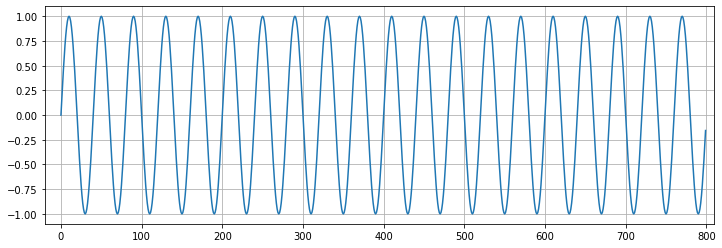

In [ ]:
# Create & plot data points
x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,4))
plt.xlim(-20,810)
plt.grid(True)
plt.plot(y.numpy());

In [ ]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

In [ ]:
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [ ]:
# From above:
# test_size = 40
# train_set = y[:-test_size]
# test_set = y[-test_size:]

window_size = 40

# Create the training dataset of sequence/label tuples:
train_data = input_data(train_set,window_size)

len(train_data) # this should equal 760-40

720

In [ ]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [ ]:
train_data[2]

(tensor([ 3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,  8.0902e-01,
          8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,  9.8769e-01,
          9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,  5.8778e-01,
          4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06, -1.5644e-01,
         -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01, -8.0902e-01,
         -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00, -9.8769e-01,
         -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01, -5.8777e-01,
         -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05,  1.5645e-01]),
 tensor([0.3090]))

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [ ]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   200
 10000
   200
   200
    50
     1
______
 10651


Epoch:  1 Loss: 0.00007963
Loss on test predictions: 0.002988798078149557


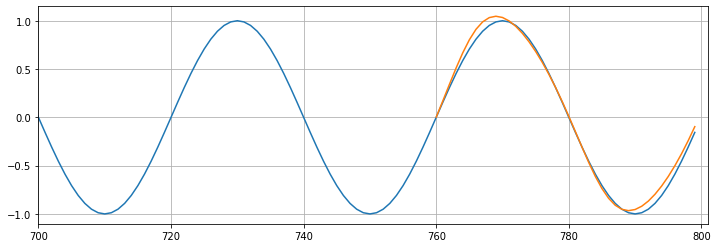

Epoch:  2 Loss: 0.00007461
Loss on test predictions: 0.0028655289206653833


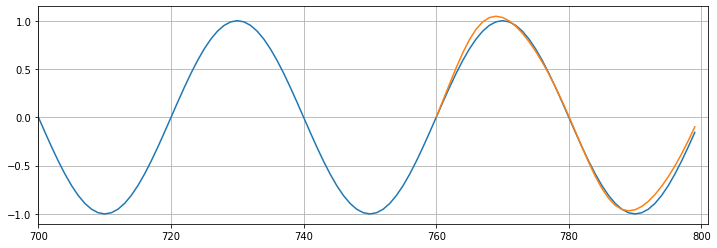

Epoch:  3 Loss: 0.00007071
Loss on test predictions: 0.002768480684608221


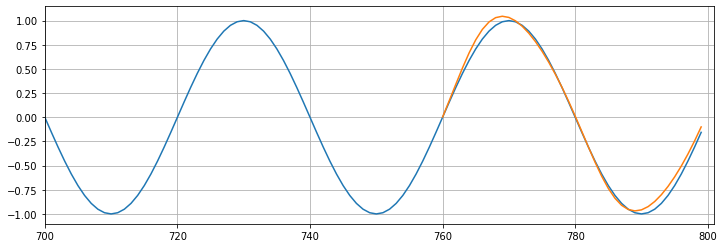

Epoch:  4 Loss: 0.00006719
Loss on test predictions: 0.0026822222862392664


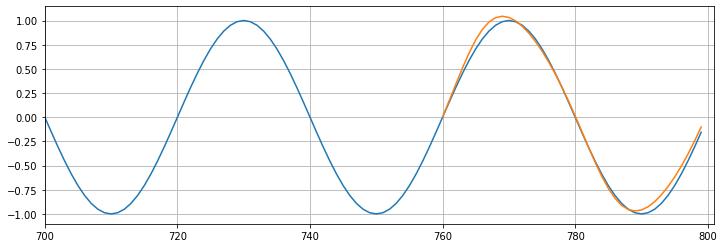

Epoch:  5 Loss: 0.00006391
Loss on test predictions: 0.0026038463693112135


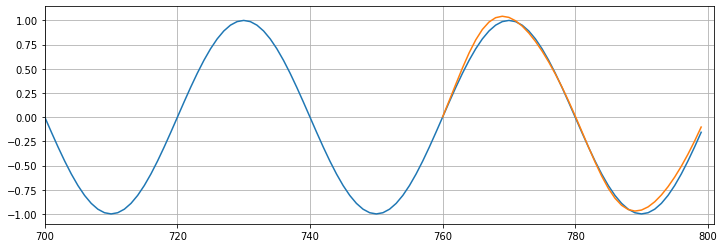

Epoch:  6 Loss: 0.00006087
Loss on test predictions: 0.002532227197661996


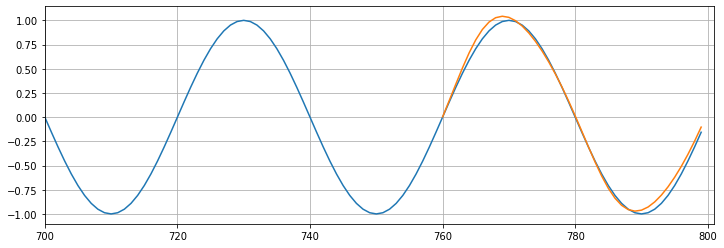

Epoch:  7 Loss: 0.00005802
Loss on test predictions: 0.0024665649980306625


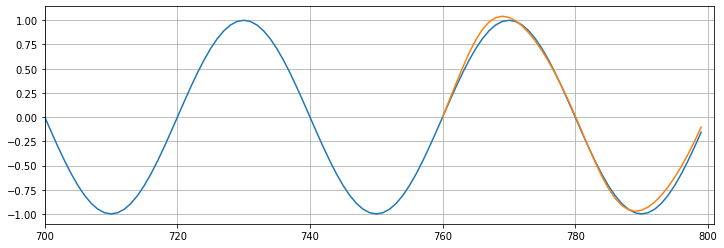

KeyboardInterrupt: ignored

In [ ]:
epochs = 10
future = 40

for i in range(epochs):
    
    # tuple-unpack the train_data set
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
    # MAKE PREDICTIONS
    # start with a list of the last 10 training records
    preds = train_set[-window_size:].tolist()

    for f in range(future):  
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

In [ ]:
epochs = 10
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_data(y,window_size)
len(all_data)

760

In [ ]:
import time
start_time = time.time()

for i in range(epochs):
    
    # tuple-unpack the entire set of data
    for seq, y_train in all_data:  
       
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00005432
Epoch:  2 Loss: 0.00005153
Epoch:  3 Loss: 0.00004915
Epoch:  4 Loss: 0.00004696
Epoch:  5 Loss: 0.00004491
Epoch:  6 Loss: 0.00004300
Epoch:  7 Loss: 0.00004122
Epoch:  8 Loss: 0.00003954
Epoch:  9 Loss: 0.00003797
Epoch: 10 Loss: 0.00003650

Duration: 69 seconds


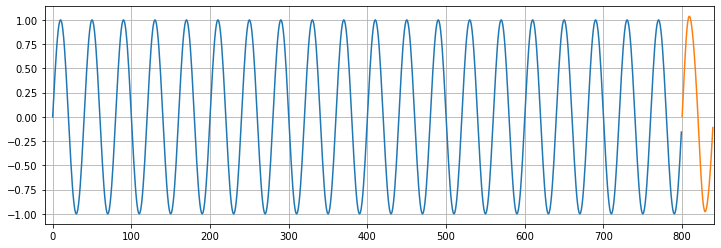

In [ ]:
preds = y[-window_size:].tolist()

for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

plt.figure(figsize=(12,4))
plt.xlim(-10,841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800,800+future),preds[window_size:])
plt.show()